# Testing QuTiP for Rabi-Cycling in the TLS

In [1]:
import qutip
import numpy as np
import sympy
import sympy.physics.quantum
from sympy import symbols
from functools import partial
import QDYN
from analytical_pulses import ampl_1freq, ampl_1freq_rwa
import matplotlib.pyplot as plt

In [2]:
sympy.init_printing()

In [3]:
%matplotlib inline

In [4]:
GHz    = 2 * np.pi
ns     = 1

In [5]:
class QuTiPEnv():
    """Namespace for use of qutip"""
    def __init__(self):
        self.Sz     = qutip.sigmaz()
        self.Sx     = qutip.sigmax()
        self.Sy     = qutip.sigmay()
        self.Id     = qutip.identity(2)
        self.ket0   = qutip.basis(2, 0)
        self.ket1   = qutip.basis(2, 1)
        self.half   = 0.5
        self.two_pi = 2 * np.pi
    @staticmethod
    def tensor(ob1, ob2):
        return qutip.tensor(ob1, ob2)
    @staticmethod
    def overlap(psi1, psi2):
        return psi1.overlap(psi2)
qutip_env = QuTiPEnv()
ket0 = qutip_env.ket0

In [6]:
def propagate(psi0, H, times):
    return qutip.mesolve(H, psi0, times, [], [])

In [7]:
def H_drift(omega, env_namespace):
    half = env_namespace.half
    return (half * omega * env_namespace.Sz)

In [8]:
def qutip_RWA_shift(w_d, H_d):
    """Shift the energies of the drift Hamiltonian into the rotating frame"""
    return H_d - qutip.Qobj(np.diag([0.5*w_d, -0.5*w_d]), dims=H_d.dims)

In [9]:
def H_ctrl(env_namespace):
    return (env_namespace.Sx)

In [10]:
def population(psi_of_t, state=0):
    return [float(abs(psi[state]))**2 for psi in psi_of_t]

## Evolution in the lab frame

In [19]:
times = np.linspace(0, 10*ns, 200)

def epsilon(t, args):
    return np.cos(6.0*GHz*t)

psi_lab = propagate(
    psi0 = ket0,
    H = [H_drift(omega=6.0*GHz, env_namespace=qutip_env),
         [H_ctrl(env_namespace=qutip_env),
          epsilon]
        ],
    times = times
).states

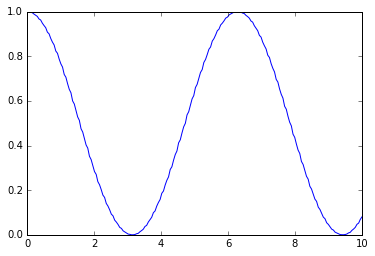

In [20]:
plt.plot(times, population(psi_lab))

## Evolution in the rotating frame

In [21]:
times = np.linspace(0, 10*ns, 200)

def epsilon(t, args):
    return 0.5

psi_rwa = propagate(
    psi0 = ket0,
    H = [qutip_RWA_shift(
            w_d=6.0*GHz,
            H_d=H_drift(omega=6.0*GHz, env_namespace=qutip_env)
         ),
         [H_ctrl(env_namespace=qutip_env),
          epsilon]
        ],
    times = times
).states

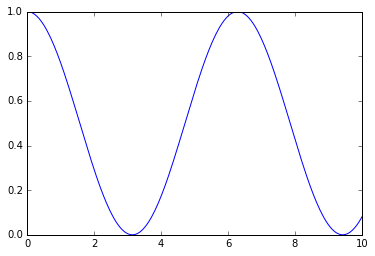

In [22]:
plt.plot(times, population(psi_rwa))